## **Mount implementation folder in google drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
%cd /content/drive/MyDrive/FYP/Implementation/data
! ls

/content/drive/.shortcut-targets-by-id/1MkC_V0CRXkQ-OsCBxF38m1Sku4w4s3TR/FYP/Implementation/data
encoded-data.csv	preprosessing-dos.csv	  UNSW-NB15_1.csv
NUSW-NB15_features.csv	selected_columns_all.csv  UNSW-NB15_2.csv
OTset.csv		SVR-predict-data.csv	  UNSW-NB15_3.csv
preprocessing.csv	testset.csv		  UNSW-NB15_4.csv


## **Load balanced training datset for DOS attacks**

Data = (x_train, y_train)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import shuffle

#get select columns for training
select_col=pd.read_csv("selected_columns_all.csv", sep=',', on_bad_lines='skip', index_col=False)
columns=list(select_col['Analysis'])

#create training dataset down sampling
df = pd.read_csv('encoded-data.csv', sep=',', on_bad_lines='skip', index_col=False)
attack_labels = ['Analysis', 'Backdoors', 'DoS', 'Exploits', 'Fuzzers', 'Generic', 'Reconnaissance', 'Shellcode', 'Worms'] + ['attack_cat','Label']


DoS_attacks = df[df['Analysis'] == 1]
Normal_Data = df[df['Label'] == 0]
frames = [DoS_attacks, Normal_Data]
result = pd.concat(frames)
X=result.drop(labels=attack_labels, axis=1)
Y=result[['Analysis']]
X.head()

undersample = RandomUnderSampler(random_state=0)
# fit and apply the transform
X, Y = undersample.fit_resample(X,Y)


x_train,y_train  = shuffle(X[columns],Y)


X_train_normalized = preprocessing.normalize(x_train)
X_train_normalized 




array([[3.21852746e-03, 2.32449205e-03, 1.01920036e-02, ...,
        3.57614162e-04, 4.47017703e-04, 8.94035405e-05],
       [3.62500000e-08, 2.12500000e-08, 1.52500000e-07, ...,
        6.25000000e-09, 6.25000000e-09, 5.00000000e-09],
       [5.33707889e-03, 2.75462136e-03, 1.96266772e-02, ...,
        3.44327670e-04, 3.27111287e-03, 1.72163835e-04],
       ...,
       [7.15499945e-05, 3.66923049e-05, 2.20153829e-04, ...,
        3.66923049e-06, 1.10076915e-05, 1.83461524e-06],
       [3.48750003e-07, 2.13750002e-07, 8.10000008e-07, ...,
        3.37500003e-08, 3.37500003e-08, 3.37500003e-08],
       [9.68081565e-03, 4.99655001e-03, 3.56004188e-02, ...,
        6.24568751e-04, 6.24568751e-04, 6.24568751e-04]])

## **Create Test Set for DOS attacks**

Data = (x_test_DOS_normalized, y_test)

In [ ]:
import pandas as pd
import numpy as np
select_col=pd.read_csv("selected_columns_all.csv", sep=',', on_bad_lines='skip', index_col=False)

columns=list(select_col['Analysis'])
test_data =pd.read_csv("testset.csv", sep=',', on_bad_lines='skip', index_col=False)
attack_labels = ['Analysis', 'Backdoors', 'DoS', 'Exploits', 'Fuzzers', 'Generic', 'Reconnaissance', 'Shellcode', 'Worms'] + ['attack_cat','Label']
attack_categories = ['Analysis', 'Backdoors', 'DoS', 'Exploits', 'Fuzzers', 'Generic', 'Reconnaissance', 'Shellcode', 'Worms'] 

DoS_attacks = test_data[test_data['attack_cat'] == 'Analysis']
# print(DoS_attacks.shape)
Normal_Data = test_data[test_data['Label'] == 0]
# print(Normal_Data.shape)

frames = [DoS_attacks, Normal_Data]
result = pd.concat(frames)
X=result.drop(labels=['attack_cat', 'Label'], axis=1)
Y=result[['Label']]
X.head()

x_test,y_test  = shuffle(X[columns],Y)

x_test = x_test.replace('-','')
x_test = x_test.replace(r'^\s*$', np.nan, regex=True)

#delete raws with missing values
for i in x_test.columns.values.tolist():
  i = x_test.loc[x_test[i].isnull()].index
  x_test = x_test.drop(index=list(i))
  y_test = y_test.drop(index=list(i))

percent_missing = x_test.isnull().sum()
missing_value_df = pd.DataFrame({'column_name': x_test.columns, 'count_missing': percent_missing, 'To be dropped': (percent_missing > 45)})
# print(missing_value_df)

x_test.head()
#encode the data
from sklearn.preprocessing import LabelEncoder

# replace hex with int
# x_test['sport'] = x_test['sport'].astype(str).apply(int, base=16)
# x_test['dsport'] = x_test['dsport'].astype(str).apply(int, base=16)

# #Create an instance of Label-encoder
labelencoder = LabelEncoder() 

# # encode columns consists with strings
x_test['srcip'] = labelencoder.fit_transform(x_test['srcip'])
x_test['dstip'] = labelencoder.fit_transform(x_test['dstip'])
x_test['proto'] = labelencoder.fit_transform(x_test['proto'])
x_test['state'] = labelencoder.fit_transform(x_test['state'])

X_test_normalized = preprocessing.normalize(x_test) 


/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (1,3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


#**Random Forrest Regression**

In [ ]:
# Fitting Random Forest Regression to the dataset
# import the regressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

#training data
x = np.array(X_train_normalized)
y = np.array(y_train)


# Number of trees in random forest
n_estimators = [2, 4, 8, 16, 32, 64, 100]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [2,4]
# Minimum number of samples required to split a node
min_samples_split = [2,3, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the param grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}




 # create regressor object
regressor = GridSearchCV(RandomForestRegressor(random_state=0),param_grid,cv=10,return_train_score=False)

# fit the regressor with x and y data
regressor.fit(x, y)


df = pd.DataFrame(regressor.cv_results_)
df

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: DataConv

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.008323,0.001306,0.000881,0.000099,True,2,auto,1,2,2,...,0.947079,0.974586,0.987350,0.963797,0.987452,0.967897,0.950249,0.969752,0.013429,196
1,0.014460,0.001236,0.000977,0.000077,True,2,auto,1,2,4,...,0.944731,0.980383,0.991023,0.963802,0.985012,0.977799,0.958276,0.974801,0.014037,179
2,0.026745,0.001341,0.001261,0.000050,True,2,auto,1,2,8,...,0.944415,0.982693,0.989781,0.966786,0.986831,0.974495,0.958363,0.975448,0.013938,157
3,0.053307,0.003673,0.002023,0.000421,True,2,auto,1,2,16,...,0.945218,0.980118,0.991090,0.969755,0.987291,0.974032,0.957481,0.975581,0.013799,151
4,0.105472,0.006428,0.003145,0.000266,True,2,auto,1,2,32,...,0.945185,0.975981,0.991227,0.973460,0.986513,0.973059,0.958405,0.975258,0.013257,161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,0.021850,0.003081,0.001376,0.000196,False,4,sqrt,2,5,8,...,0.968190,0.971901,0.991216,0.985565,0.983295,0.975887,0.968273,0.979055,0.008367,138
332,0.039961,0.002884,0.002162,0.000300,False,4,sqrt,2,5,16,...,0.969056,0.971760,0.991569,0.990404,0.986383,0.980751,0.968103,0.981370,0.008557,125
333,0.088071,0.020272,0.003672,0.000520,False,4,sqrt,2,5,32,...,0.969480,0.973972,0.993256,0.990360,0.986283,0.982666,0.968902,0.982638,0.008509,111
334,0.174314,0.031281,0.008609,0.005842,False,4,sqrt,2,5,64,...,0.968804,0.976802,0.994641,0.991483,0.986347,0.985355,0.970253,0.984157,0.008615,86


In [ ]:
df[['param_bootstrap', 	'param_max_depth', 	'param_max_features', 	'param_min_samples_leaf', 	'param_min_samples_split', 	'param_n_estimators','mean_test_score']]

,param_bootstrap,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,mean_test_score
0,True,2,auto,1,2,2,0.969752
1,True,2,auto,1,2,4,0.974801
2,True,2,auto,1,2,8,0.975448
3,True,2,auto,1,2,16,0.975581
4,True,2,auto,1,2,32,0.975258
...,...,...,...,...,...,...,...
331,False,4,sqrt,2,5,8,0.979055
332,False,4,sqrt,2,5,16,0.981370
333,False,4,sqrt,2,5,32,0.982638
334,False,4,sqrt,2,5,64,0.984157


In [ ]:
regressor.best_params_

{'bootstrap': False,
 'max_depth': 4,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 4}

#**Train the model**

In [ ]:
from sklearn.ensemble import RandomForestRegressor

#training data
x = np.array(X_train_normalized)
y = np.array(y_train)


 # create regressor object
regressor = RandomForestRegressor(bootstrap=False,max_depth=4,max_features= 'auto',min_samples_leaf=1,min_samples_split=2,n_estimators=4)

# fit the regressor with x and y data
regressor.fit(x, y)

y_pred = regressor.predict(x)


<ipython-input-22-d9f007f5095a>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regressor.fit(x, y)


In [ ]:
from sklearn.metrics import accuracy_score

for i in range(1,100):
  y_predict_class = [1 if p > i/100 else 0 for p in y_pred]
  print("Accuracy when threshould = ",i/100, round(accuracy_score(y, y_predict_class), 6))

Accuracy when threshould =  0.01 0.994661
Accuracy when threshould =  0.02 0.994661
Accuracy when threshould =  0.03 0.994661
Accuracy when threshould =  0.04 0.994661
Accuracy when threshould =  0.05 0.994661
Accuracy when threshould =  0.06 0.994661
Accuracy when threshould =  0.07 0.994661
Accuracy when threshould =  0.08 0.99843
Accuracy when threshould =  0.09 0.99843
Accuracy when threshould =  0.1 0.99843
Accuracy when threshould =  0.11 0.99843
Accuracy when threshould =  0.12 0.99843
Accuracy when threshould =  0.13 0.99843
Accuracy when threshould =  0.14 0.99843
Accuracy when threshould =  0.15 0.99843
Accuracy when threshould =  0.16 0.99843
Accuracy when threshould =  0.17 0.99843
Accuracy when threshould =  0.18 0.99843
Accuracy when threshould =  0.19 0.99843
Accuracy when threshould =  0.2 0.99843
Accuracy when threshould =  0.21 0.99843
Accuracy when threshould =  0.22 0.99843
Accuracy when threshould =  0.23 0.99843
Accuracy when threshould =  0.24 0.99843
Accuracy wh

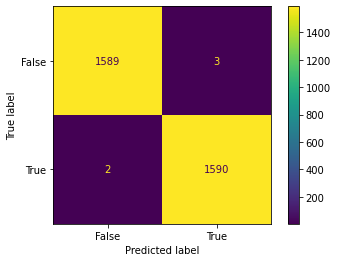

In [ ]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

threshould =0.5

y_predict_class = [1 if p > threshould else 0 for p in y_pred]
confusion_matrix = metrics.confusion_matrix(y, y_predict_class)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show() 


**Test Set Accuracy**

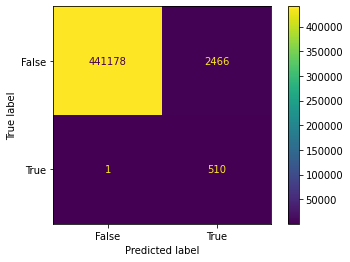

Accuracy when threshould =  0.6 0.994446


In [ ]:
x_test_array = np.array(X_test_normalized)
y_test_array = np.array(y_test)
y_pred_test_set = regressor.predict(x_test_array)


threshould =0.6


y_predict_test_set_class = [1 if p > threshould else 0 for p in y_pred_test_set]
confusion_matrix = metrics.confusion_matrix(y_test_array, y_predict_test_set_class)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show() 

print("Accuracy when threshould = ",threshould, round(accuracy_score(y_test_array, y_predict_test_set_class), 6))

In [ ]:
# F score : 0.2925

#**Save Model**

In [ ]:
from joblib import Parallel, delayed
import joblib
from sklearn.ensemble import RandomForestRegressor

#training data
x = np.array(X_train_normalized)
y = np.array(y_train)


 # create regressor object
regressor = RandomForestRegressor(random_state=0,bootstrap=False,max_depth=4,max_features= 'auto',min_samples_leaf=1,min_samples_split=2,n_estimators=4)

# fit the regressor with x and y data
regressor.fit(x, y)

# Save the model as a pickle in a file
joblib.dump(regressor, 'RandomForrest_Analysis.pkl')

# Load the model from the file
RF_from_joblib = joblib.load('RandomForrest_Analysis.pkl')

# Use the loaded model to make predictions
x_test_array = np.array(X_test_normalized)
y_test_array = np.array(y_test)
y_pred_test_set = RF_from_joblib.predict(x_test_array)

<ipython-input-5-e14059c112d2>:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regressor.fit(x, y)


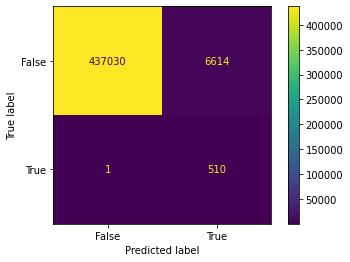

Accuracy when threshould =  0.6 0.985107


In [ ]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics
from sklearn.metrics import accuracy_score

threshould =0.6


y_predict_test_set_class = [1 if p > threshould else 0 for p in y_pred_test_set]
confusion_matrix = metrics.confusion_matrix(y_test_array, y_predict_test_set_class)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show() 

print("Accuracy when threshould = ",threshould, round(accuracy_score(y_test_array, y_predict_test_set_class), 6))

<!-- F score : 0.2925 -->